In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial.distance import pdist, squareform

def construct_similarity_network(data_path, top_n=3, method="pearson", output_file=None):
    """
    Constructs a patient similarity network from a selected omics file.
    
    Parameters:
      data_path: Path to the CSV file with selected features (first column should be "Sample_ID").
      top_n: Number of top similar neighbors to connect.
      method: "pearson" or "euclidean" to calculate similarity.
      output_file: If provided, saves the edgelist to this file.
      
    Returns:
      G: A NetworkX graph.
    """
    # Load data and separate Sample_ID and features
    df = pd.read_csv(data_path)
    sample_ids = df["Sample_ID"].values
    features = df.drop(columns=["Sample_ID"]).values
    
    if method == "pearson":
        # Compute Pearson correlation matrix (samples x samples)
        similarity_matrix = np.corrcoef(features)
    elif method == "euclidean":
        dist_matrix = squareform(pdist(features, metric="euclidean"))
        similarity_matrix = 1 / (1 + dist_matrix)  # convert distance to similarity
    else:
        raise ValueError("Method not recognized!")
    
    # Create a DataFrame for similarity matrix for easier handling.
    sim_df = pd.DataFrame(similarity_matrix, index=sample_ids, columns=sample_ids)
    
    # Create a graph: for each patient, connect to top_n most similar (excluding self).
    G = nx.Graph()
    G.add_nodes_from(sample_ids)
    for sid in sample_ids:
        # Exclude self by dropping the current sample.
        neighbors = sim_df.loc[sid].drop(sid)
        # Select top_n neighbors
        top_neighbors = neighbors.nlargest(top_n)
        for neighbor, sim in top_neighbors.items():
            G.add_edge(sid, neighbor, weight=sim)
            
    if output_file:
        nx.write_edgelist(G, output_file, data=["weight"])
        print(f"Network saved to {output_file} with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    
    return G

# Construct networks for each omics type
G_mrna = construct_similarity_network("mrna_selected.csv", top_n=3, method="pearson", output_file="mrna_network.edgelist")
G_methylation = construct_similarity_network("methylation_selected.csv", top_n=3, method="pearson", output_file="methylation_network.edgelist")
G_cna = construct_similarity_network("cna_selected.csv", top_n=3, method="pearson", output_file="cna_network.edgelist")


Network saved to mrna_network.edgelist with 199 nodes and 456 edges.
Network saved to methylation_network.edgelist with 199 nodes and 426 edges.
Network saved to cna_network.edgelist with 199 nodes and 404 edges.


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from gower import gower_matrix  # Install with: pip install gower

# -------------------- 1. Load Clinical Data -------------------- #
clinical_data = pd.read_csv("data_clinical_patient_preprocessed.csv")

# Ensure the first column is named 'Sample_ID' and convert it to a plain string
if "Sample_ID" not in clinical_data.columns:
    clinical_data.rename(columns={clinical_data.columns[0]: "Sample_ID"}, inplace=True)
clinical_data["Sample_ID"] = clinical_data["Sample_ID"].astype(str)

# Drop the Survival_Label column (if it exists) so it is not used for similarity calculation
if "Survival_Label" in clinical_data.columns:
    clinical_data = clinical_data.drop(columns=["Survival_Label"])

def construct_clinical_similarity_network(data, top_n=3, output_file="clinical_network.edgelist"):
    """
    Constructs a patient similarity network using Gower distance for mixed clinical data.
    It excludes identifier/outcome columns (Sample_ID and Survival_Label) from the similarity calculation.
    """
    # Exclude Sample_ID from the feature matrix.
    features_df = data.drop(columns=["Sample_ID"])
    
    # Convert the Sample_ID column to a list of strings for graph nodes.
    sample_ids = data["Sample_ID"].values.tolist()
    
    # Compute Gower similarity matrix from the clinical features.
    feature_matrix = features_df.values
    gower_distance_matrix = gower_matrix(feature_matrix)
    gower_sim_matrix = 1 - gower_distance_matrix  # Convert distance to similarity
    
    # Create a DataFrame for the similarity matrix with sample_ids as both index and columns.
    similarity_df = pd.DataFrame(gower_sim_matrix, index=sample_ids, columns=sample_ids)
    
    # Remove self-similarity by setting the diagonal to 0.
    np.fill_diagonal(gower_sim_matrix, 0)
    
    # Create an empty graph and add nodes from sample_ids.
    G = nx.Graph()
    G.add_nodes_from(sample_ids)
    
    # For each patient, add edges to the top_n most similar patients.
    for patient in sample_ids:
        # Get the top_n neighbors (highest similarity values) for the current patient.
        neighbors = similarity_df.loc[patient].nlargest(top_n)
        for neighbor, similarity in neighbors.items():
            G.add_edge(patient, neighbor, weight=similarity)
    
    # Save the network edge list to a file.
    nx.write_edgelist(G, output_file, data=["weight"])
    print(f"Clinical similarity network saved as {output_file}.")
    return G

# Construct and save the clinical network.
clinical_network = construct_clinical_similarity_network(clinical_data, top_n=3, output_file="clinical_network.edgelist")


Clinical similarity network saved as clinical_network.edgelist.


In [3]:
from torch_geometric.utils import from_networkx
import torch
import pandas as pd
import networkx as nx

# --- Existing code for omics networks using mrna network as base ---
# Assume G_mrna is already constructed from omics data.
common_sample_ids = list(G_mrna.nodes())
print("Common sample IDs count (omics base):", len(common_sample_ids))

def load_omics_features(data_path, sample_ids):
    """
    Loads the omics data file and returns a feature matrix (ordered by sample_ids).
    """
    df = pd.read_csv(data_path)
    df["Sample_ID"] = df["Sample_ID"].astype(str)
    df_ordered = df.set_index("Sample_ID").reindex(sample_ids)
    return torch.tensor(df_ordered.values, dtype=torch.float)

# Create feature matrices for each omics view.
X_mrna = load_omics_features("mrna_selected.csv", common_sample_ids)
X_methylation = load_omics_features("methylation_selected.csv", common_sample_ids)
X_cna = load_omics_features("cna_selected.csv", common_sample_ids)

# Convert one of the networks (mrna network) to a PyG Data object.
data_common = from_networkx(G_mrna, group_edge_attrs=["weight"])

# Create one data object per omics view by assigning the corresponding features.
data_mrna = data_common.clone()
data_mrna.x = X_mrna

data_methylation = data_common.clone()
data_methylation.x = X_methylation

data_cna = data_common.clone()
data_cna.x = X_cna

print("mRNA feature shape:", data_mrna.x.shape)
print("Methylation feature shape:", data_methylation.x.shape)
print("CNA feature shape:", data_cna.x.shape)

# --- New Code to Integrate Clinical Data ---

# Load clinical network (built using Gower similarity) from its edge list.
# This network should have been created from your clinical data.
G_clinical = nx.read_edgelist("clinical_network.edgelist", nodetype=str, data=[("weight", float)])
common_clinical_ids = list(G_clinical.nodes())
print("Common sample IDs count (clinical base):", len(common_clinical_ids))

def load_clinical_features(data_path, sample_ids):
    """
    Loads the clinical data file and returns a feature matrix (ordered by sample_ids).
    """
    df = pd.read_csv(data_path)
    df["Sample_ID"] = df["Sample_ID"].astype(str)
    if "Survival_Label" in df.columns:
        df = df.drop(columns=["Survival_Label"])
    # Reorder by the given sample_ids
    df_ordered = df.set_index("Sample_ID").reindex(sample_ids)
    # Optionally, fill missing values if any remain
    df_ordered.fillna(0, inplace=True)
    return torch.tensor(df_ordered.values, dtype=torch.float)

# Load clinical features from the preprocessed clinical data.
X_clinical = load_clinical_features("data_clinical_patient_preprocessed.csv", common_clinical_ids)

# Convert the clinical network into a PyG Data object.
data_common_clinical = from_networkx(G_clinical, group_edge_attrs=["weight"])

# Create the clinical data object by assigning clinical features.
data_clinical = data_common_clinical.clone()
data_clinical.x = X_clinical

print("Clinical feature shape:", data_clinical.x.shape)


Common sample IDs count (omics base): 199
mRNA feature shape: torch.Size([199, 37])
Methylation feature shape: torch.Size([199, 30])
CNA feature shape: torch.Size([199, 4])
Common sample IDs count (clinical base): 199
Clinical feature shape: torch.Size([199, 61])


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GATModel(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_heads=1, dropout=0.6):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_features, hidden_features, heads=num_heads, dropout=dropout)
        # Output dimension of conv1 is hidden_features * num_heads
        self.conv2 = GATConv(hidden_features * num_heads, out_features, heads=1, concat=False, dropout=dropout)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # shape: (num_samples, out_features)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters (adjust as needed)
embedding_dim = 16  # Output embedding size for each branch
hidden_dim = 16
num_heads = 4

# Create GAT model instances for each omics view.
model_mrna = GATModel(in_features=data_mrna.x.shape[1], hidden_features=hidden_dim, out_features=embedding_dim, num_heads=num_heads).to(device)
model_methylation = GATModel(in_features=data_methylation.x.shape[1], hidden_features=hidden_dim, out_features=embedding_dim, num_heads=num_heads).to(device)
model_cna = GATModel(in_features=data_cna.x.shape[1], hidden_features=hidden_dim, out_features=embedding_dim, num_heads=num_heads).to(device)

# --- Integrate Clinical Data ---
# Assuming you have already created a PyG Data object for clinical data named 'data_clinical'
# For example, using your previous clinical network and features.
# data_clinical should be similar to data_mrna, but with clinical features.
model_clinical = GATModel(in_features=data_clinical.x.shape[1], hidden_features=hidden_dim, out_features=embedding_dim, num_heads=num_heads).to(device)

# Move PyG data objects to the device.
data_mrna = data_mrna.to(device)
data_methylation = data_methylation.to(device)
data_cna = data_cna.to(device)
data_clinical = data_clinical.to(device)

print("mRNA feature shape:", data_mrna.x.shape)
print("Methylation feature shape:", data_methylation.x.shape)
print("CNA feature shape:", data_cna.x.shape)
print("Clinical feature shape:", data_clinical.x.shape)


Using device: cuda
mRNA feature shape: torch.Size([199, 37])
Methylation feature shape: torch.Size([199, 30])
CNA feature shape: torch.Size([199, 4])
Clinical feature shape: torch.Size([199, 61])


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GATConv
import pandas as pd
from scipy.stats import mode

# ----- Define the GAT Model (for all branches) -----
class GATModel(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_heads=1, dropout=0.6):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_features, hidden_features, heads=num_heads, dropout=dropout)
        # Output of conv1 is hidden_features * num_heads.
        self.conv2 = GATConv(hidden_features * num_heads, out_features, heads=1, concat=False, dropout=dropout)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # shape: (num_samples, out_features)

# ----- Define VCDN for Four Views -----
class VCDN_four(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(VCDN_four, self).__init__()
        # For four views, compute six pairwise outer products.
        # The resulting fused vector has length 6 * embedding_dim^2.
        self.fc = nn.Sequential(
            nn.Linear(6 * embedding_dim * embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, z1, z2, z3, z4):
        # z1, z2, z3, z4: shape (num_samples, embedding_dim)
        outer12 = torch.bmm(z1.unsqueeze(2), z2.unsqueeze(1))
        outer13 = torch.bmm(z1.unsqueeze(2), z3.unsqueeze(1))
        outer14 = torch.bmm(z1.unsqueeze(2), z4.unsqueeze(1))
        outer23 = torch.bmm(z2.unsqueeze(2), z3.unsqueeze(1))
        outer24 = torch.bmm(z2.unsqueeze(2), z4.unsqueeze(1))
        outer34 = torch.bmm(z3.unsqueeze(2), z4.unsqueeze(1))
        flat12 = outer12.view(outer12.size(0), -1)
        flat13 = outer13.view(outer13.size(0), -1)
        flat14 = outer14.view(outer14.size(0), -1)
        flat23 = outer23.view(outer23.size(0), -1)
        flat24 = outer24.view(outer24.size(0), -1)
        flat34 = outer34.view(outer34.size(0), -1)
        fused = torch.cat([flat12, flat13, flat14, flat23, flat24, flat34], dim=1)
        output = self.fc(fused)
        return output  # shape: (num_samples, output_dim)

# ----- Device Setup -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----- Hyperparameters -----
embedding_dim = 16  # Output embedding size for each branch
hidden_dim = 16
num_heads = 4

# ----- Instantiate GAT Models for Each View -----
# Assume that data_mrna, data_methylation, data_cna, and data_clinical are PyG Data objects
model_mrna = GATModel(in_features=data_mrna.x.shape[1], hidden_features=hidden_dim, out_features=embedding_dim, num_heads=num_heads).to(device)
model_methylation = GATModel(in_features=data_methylation.x.shape[1], hidden_features=hidden_dim, out_features=embedding_dim, num_heads=num_heads).to(device)
model_cna = GATModel(in_features=data_cna.x.shape[1], hidden_features=hidden_dim, out_features=embedding_dim, num_heads=num_heads).to(device)
model_clinical = GATModel(in_features=data_clinical.x.shape[1], hidden_features=hidden_dim, out_features=embedding_dim, num_heads=num_heads).to(device)

# ----- Move All PyG Data Objects to Device -----
data_mrna = data_mrna.to(device)
data_methylation = data_methylation.to(device)
data_cna = data_cna.to(device)
data_clinical = data_clinical.to(device)

print("mRNA feature shape:", data_mrna.x.shape)
print("Methylation feature shape:", data_methylation.x.shape)
print("CNA feature shape:", data_cna.x.shape)
print("Clinical feature shape:", data_clinical.x.shape)

# ----- Instantiate VCDN for Four Views -----
vcdn_four = VCDN_four(embedding_dim=embedding_dim, hidden_dim=128, output_dim=2).to(device)

# ----- Load Survival Labels and Create Labels Tensor -----
df_labels = pd.read_csv("survival_labels.csv")
df_labels["Sample_ID"] = df_labels["Sample_ID"].astype(str)
label_dict = dict(zip(df_labels["Sample_ID"], df_labels["Survival_Label"]))
# Here, we assume that the ordering of labels for fusion is given by common_sample_ids (which should match clinical data ordering)
# If your common_sample_ids come from clinical network, use that ordering.
labels = [label_dict.get(sid, 0) for sid in common_sample_ids]
labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)

# ----- Define Optimizer and Loss -----
optimizer = optim.Adam(list(model_mrna.parameters()) +
                       list(model_methylation.parameters()) +
                       list(model_cna.parameters()) +
                       list(model_clinical.parameters()) +
                       list(vcdn_four.parameters()),
                       lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# ----- Training Loop -----
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    model_mrna.train()
    model_methylation.train()
    model_cna.train()
    model_clinical.train()
    vcdn_four.train()
    optimizer.zero_grad()
    
    # Obtain embeddings from each branch
    emb_mrna = model_mrna(data_mrna)            # (num_samples, embedding_dim)
    emb_methylation = model_methylation(data_methylation)
    emb_cna = model_cna(data_cna)
    emb_clinical = model_clinical(data_clinical)
    
    # Fuse embeddings using VCDN for 4 views
    fused_output = vcdn_four(emb_mrna, emb_methylation, emb_cna, emb_clinical)  # (num_samples, 2)
    
    loss = criterion(fused_output, labels_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0 or epoch == 1:
        _, preds = torch.max(fused_output, 1)
        correct = (preds == labels_tensor).sum().item()
        acc = correct / labels_tensor.size(0)
        print(f"Epoch {epoch:03d}: Loss = {loss.item():.4f}, Accuracy = {acc:.4f}")

# ----- Evaluation and Saving Fused Embeddings -----
model_mrna.eval()
model_methylation.eval()
model_cna.eval()
model_clinical.eval()
vcdn_four.eval()

with torch.no_grad():
    emb_mrna = model_mrna(data_mrna)
    emb_methylation = model_methylation(data_methylation)
    emb_cna = model_cna(data_cna)
    emb_clinical = model_clinical(data_clinical)
    fused_output = vcdn_four(emb_mrna, emb_methylation, emb_cna, emb_clinical)
    
fused_embeddings = fused_output.cpu().numpy()
df_fused = pd.DataFrame(fused_embeddings, columns=["Fused_1", "Fused_2"])
df_fused.insert(0, "Sample_ID", common_sample_ids)  # Ensure ordering matches your clinical network
df_fused.to_csv("fused_embeddings.csv", index=False)
print("Fused embeddings saved to 'fused_embeddings.csv'.")


Using device: cuda
mRNA feature shape: torch.Size([199, 37])
Methylation feature shape: torch.Size([199, 30])
CNA feature shape: torch.Size([199, 4])
Clinical feature shape: torch.Size([199, 61])
Epoch 001: Loss = 0.7280, Accuracy = 0.4523
Epoch 010: Loss = 0.6667, Accuracy = 0.6884
Epoch 020: Loss = 0.5055, Accuracy = 0.7839
Epoch 030: Loss = 0.5480, Accuracy = 0.7940
Epoch 040: Loss = 0.5005, Accuracy = 0.7889
Epoch 050: Loss = 0.4945, Accuracy = 0.7940
Epoch 060: Loss = 0.4420, Accuracy = 0.7990
Epoch 070: Loss = 0.4234, Accuracy = 0.8090
Epoch 080: Loss = 0.3592, Accuracy = 0.8241
Epoch 090: Loss = 0.3729, Accuracy = 0.8241
Epoch 100: Loss = 0.3579, Accuracy = 0.8392
Fused embeddings saved to 'fused_embeddings.csv'.


In [6]:

import pandas as pd

# Load fused embeddings and survival labels.
df_features = pd.read_csv("fused_embeddings.csv")  # e.g., contains Sample_ID, Fused_1, Fused_2, ...
df_labels = pd.read_csv("survival_labels.csv")      # contains Sample_ID and Survival_Label

# Merge based on Sample_ID (ensure Sample_ID is of the same type)
df_features["Sample_ID"] = df_features["Sample_ID"].astype(str)
df_labels["Sample_ID"] = df_labels["Sample_ID"].astype(str)
df = pd.merge(df_features, df_labels, on="Sample_ID", how="inner")
print("Merged data shape:", df.shape)



Merged data shape: (199, 4)


In [7]:
import numpy as np

# Assume that 'Survival_Label' is the target column (binary: 0/1)
# and all columns except 'Sample_ID' and 'Survival_Label' are features.
X = df.drop(columns=["Sample_ID", "Survival_Label"]).values
y = df["Survival_Label"].values

print("Feature shape:", X.shape)
print("Labels distribution:", np.unique(y, return_counts=True))


Feature shape: (199, 2)
Labels distribution: (array([0, 1], dtype=int64), array([ 88, 111], dtype=int64))


In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets (20% test, stratified by label)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (139, 2) Test shape: (60, 2)



MLP Accuracy: 0.9667
Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.94      0.97        33

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



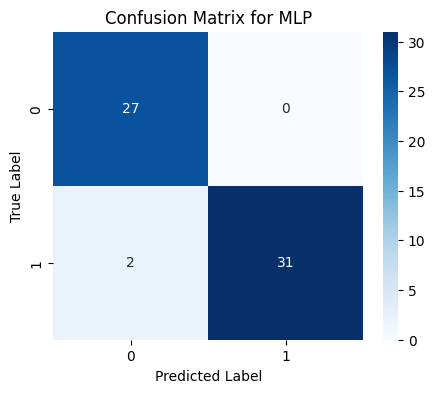


SVM Accuracy: 0.9667
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.94      0.97        33

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



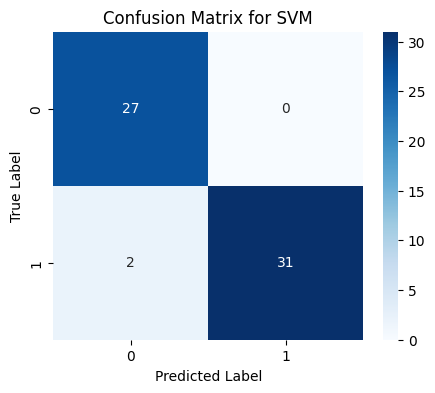


XGBoost Accuracy: 0.9833
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      0.97      0.98        33

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



C:\Users\varun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


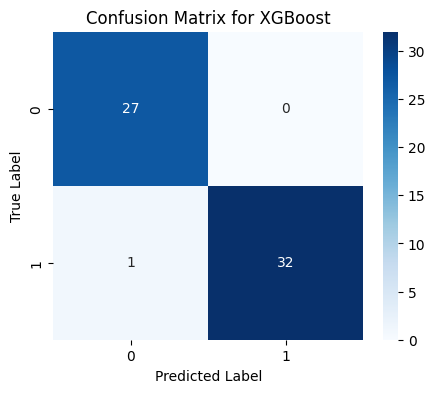


Random Forest Accuracy: 0.9167
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        27
           1       0.94      0.91      0.92        33

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



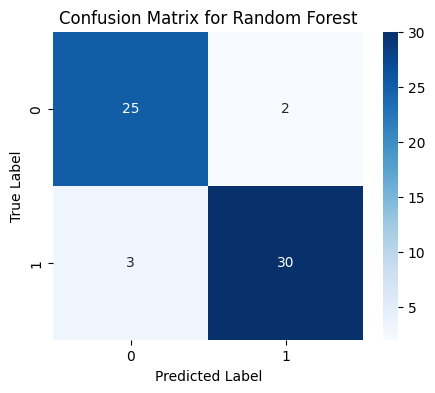

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Define classifiers
clf_mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=500, random_state=42)
clf_svm = SVC(kernel="rbf", probability=True, random_state=42)
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
clf_rf = RandomForestClassifier(n_estimators=200, random_state=42)

classifiers = {
    "MLP": clf_mlp,
    "SVM": clf_svm,
    "XGBoost": clf_xgb,
    "Random Forest": clf_rf
}

results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    
    # Compute and visualize confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {"accuracy": acc, "confusion_matrix": cm}
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


C:\Users\varun\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Ensemble Accuracy: 0.9500
Classification Report for Ensemble:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        27
           1       1.00      0.91      0.95        33

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



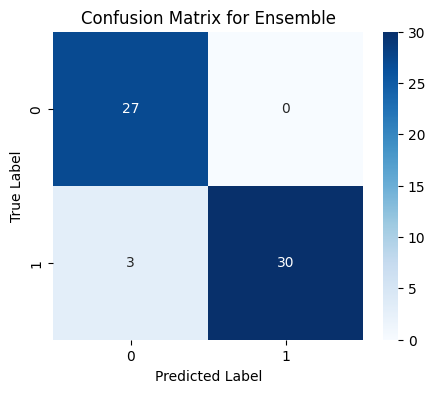

In [10]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ("MLP", clf_mlp),
        ("SVM", clf_svm),
        ("XGBoost", clf_xgb),
        ("RF", clf_rf)
    ],
    voting="hard"
)

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"\nEnsemble Accuracy: {acc_ensemble:.4f}")
print("Classification Report for Ensemble:\n", classification_report(y_test, y_pred_ensemble))
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Ensemble")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc, confusion_matrix
)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from tabulate import tabulate
import itertools

#  1. Load GAT Embeddings and Survival Labels
print("Loading GAT embeddings and survival labels...")
embeddings = pd.read_csv("fused_embeddings.csv")
survival_labels = pd.read_csv("survival_labels.csv")

embeddings["Sample_ID"] = embeddings["Sample_ID"].astype(str)
survival_labels["Sample_ID"] = survival_labels["Sample_ID"].astype(str)

#  2. Merge Labels with Embeddings
merged_data = pd.merge(survival_labels, embeddings, on="Sample_ID", how="inner")
X = merged_data.drop(columns=["Sample_ID", "Survival_Label"]).values
y = merged_data["Survival_Label"].values

# 3. Define Classifiers
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), activation="relu", solver="adam", max_iter=5000, random_state=42)
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric="logloss", random_state=42)
rf = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=42)
svm = SVC(kernel="rbf", C=1, probability=True, random_state=42)

ensemble = VotingClassifier(estimators=[
    ('MLP', mlp),
    ('XGB', xgb),
    ('RF', rf),
    ('SVM', svm)
], voting="soft")

models = {
    "MLP": mlp,
    "XGB": xgb,
    "RandomForest": rf,
    "SVM": svm,
    "Ensemble": ensemble
}

# 4. Cross-Validation Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_summary = {model_name: [] for model_name in models.keys()}

# 5. Cross-Validation Loop
for model_name, model in models.items():
    print(f"\n{'=' * 20}\nTraining {model_name} with 5-Fold Cross-Validation")
    fold = 1
    fold_results = []

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Handle imbalance with SMOTE if needed
        if np.min(np.bincount(y_train)) / np.max(np.bincount(y_train)) < 0.5:
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average="macro")
        f1_weighted = f1_score(y_test, y_pred, average="weighted")
        sensitivity = recall_score(y_test, y_pred, pos_label=1)  # True Positive Rate
        specificity = recall_score(y_test, y_pred, pos_label=0)  # True Negative Rate
        precision = precision_score(y_test, y_pred, average="macro")
        recall_overall = recall_score(y_test, y_pred, average="macro")
        auc_score = roc_auc_score(y_test, y_prob)

        fold_result = {
            "Fold": fold,
            "Accuracy": accuracy,
            "Macro-F1": f1_macro,
            "Weighted-F1": f1_weighted,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "Precision": precision,
            "Recall": recall_overall,
            "AUC": auc_score
        }

        fold_results.append(fold_result)
        print(f"Fold {fold} - Accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}, Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}, Precision: {precision:.3f}, Recall: {recall_overall:.3f}")
        fold += 1

    results_summary[model_name] = fold_results

#  6. Aggregate Results and Display Summary
final_summary = []

for model_name, folds in results_summary.items():
    metrics_df = pd.DataFrame(folds)
    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    final_summary.append({
        "Model": model_name,
        "Accuracy": f"{avg_metrics['Accuracy']:.3f} ± {std_metrics['Accuracy']:.3f}",
        "Macro-F1": f"{avg_metrics['Macro-F1']:.3f} ± {std_metrics['Macro-F1']:.3f}",
        "Weighted-F1": f"{avg_metrics['Weighted-F1']:.3f} ± {std_metrics['Weighted-F1']:.3f}",
        "Sensitivity": f"{avg_metrics['Sensitivity']:.3f} ± {std_metrics['Sensitivity']:.3f}",
        "Specificity": f"{avg_metrics['Specificity']:.3f} ± {std_metrics['Specificity']:.3f}",
        "Precision": f"{avg_metrics['Precision']:.3f} ± {std_metrics['Precision']:.3f}",
        "Recall": f"{avg_metrics['Recall']:.3f} ± {std_metrics['Recall']:.3f}",
        "AUC": f"{avg_metrics['AUC']:.3f} ± {std_metrics['AUC']:.3f}"
    })

summary_df = pd.DataFrame(final_summary)
summary_df.to_csv("cross_validation_results.csv", index=False)

print("\nFinal Cross-Validation Summary:")
print(tabulate(summary_df, headers="keys", tablefmt="pretty"))


Loading GAT embeddings and survival labels...

Training MLP with 5-Fold Cross-Validation
Fold 1 - Accuracy: 0.925, AUC: 0.995, Sensitivity: 0.913, Specificity: 0.941, Precision: 0.922, Recall: 0.927
Fold 2 - Accuracy: 0.900, AUC: 0.970, Sensitivity: 1.000, Specificity: 0.778, Precision: 0.923, Recall: 0.889
Fold 3 - Accuracy: 0.900, AUC: 0.965, Sensitivity: 0.909, Specificity: 0.889, Precision: 0.899, Recall: 0.899
Fold 4 - Accuracy: 0.900, AUC: 0.982, Sensitivity: 0.909, Specificity: 0.889, Precision: 0.899, Recall: 0.899
Fold 5 - Accuracy: 0.923, AUC: 0.984, Sensitivity: 0.909, Specificity: 0.941, Precision: 0.921, Recall: 0.925

Training XGB with 5-Fold Cross-Validation
Fold 1 - Accuracy: 0.925, AUC: 0.990, Sensitivity: 0.913, Specificity: 0.941, Precision: 0.922, Recall: 0.927
Fold 2 - Accuracy: 0.950, AUC: 0.957, Sensitivity: 1.000, Specificity: 0.889, Precision: 0.958, Recall: 0.944
Fold 3 - Accuracy: 0.825, AUC: 0.947, Sensitivity: 0.818, Specificity: 0.833, Precision: 0.823, Re